# Generative AI and Risk Information

## About this Course

### What you will learn

- You will learn about understand fundamental concepts in the field of GenAI such as LLMs, embedding models, RAG and agents 
- You will get to know and directly work with GenAI platforms and solution providers such as OpenAI, HuggingFace, Ollama and Tavily
- You will parse, chunk and vectorize annual company reports using two popular GenAI frameworks LangChain and LlamaIndex to build a vector store
- Based on the vector store you will learn how to develop an agentic RAG system using LangGraph and working with fundamental graph concepts such as
    - states
    - routing
    - map-reduce
    - tool calling

### Prerequisites

GenAI applications typically depend strongly on the integration of third party models and tools. So does this course. While we need to sign up for some third party accounts to use their APIs, all of the services used in this course are free of charge. Please follow the instruction below to set yourself up for the rest of the course.

1. [**HuggingFace**]([https://huggingface.co/]): We use HuggingFace to get access to embedding models that can either be downloaded locally or it is also possible to use HuggingFace's inference API
    - Create a free account
    - Generate a read access token
        
        <img src="img/huggingface.png" alt="HuggingFace Access Token" width="1000">

    - Save the token in your .env file: <br>
        HUGGINGFACE_API_KEY = \<Your HuggingFace token\>

2. [**Tavily**]([https://huggingface.co/]): We use Tavily as search engine designed for to get access to real-time information from the web.
    - Create a free account
    - Generate an API key
        
        <img src="img/tavily.png" alt="HuggingFace API Key" width="1000">

    - Save the key in your .env file: <br>
        TAVILY_API_KEY = \<Your Tavily key\>

3. [Ollama](https://ollama.com/): We use Ollama to run open source LLMs locally on your computer or a server. It acts as a model manager and runtime, handling the complexities of downloading, configuring, and using open-source LLMs.
    - Download Ollama

        <img src="img/ollama.png" alt="HuggingFace Access Token" width="1000">

4. [**OpenAI**]([https://openai.com/]) (*optional*): We use OpenAI's GPT LLM model series as an alternative to the free, open-source, LLMs. Using with OpenAI's models is *not* free of charge. You can still follow the entire course material if you do not create an OpenAI account.
    - Create an account. Credit card information required!
    - Generate an API key
        
        <img src="img/openai3.png" alt="Open API Key" width="700">

    - Save the key in your .env file: <br>
        OPENAI_API_KEY = \<Your OpenAI key\>

## What is Generative AI?

> Generative AI (GenAI) is a special type of Artificial Intelligence that can learn from and mimic large amounts of data to create content such as text, images, music, videos, code, and more.

<img src="img/ai_ml_dl_nlp_genai.png" alt="AI, ML, DL, NLP & GenAI" style="width: 55vw; min-width: 330px;"/>
<p>Image source: Illustration by the author</p>

## Application of Generative AI in Risk Management

Making use of GenAI offers a great leverage for managing risks. The following provides some arguments how GenAI opens new ways to think about and manage corporate risks.

**Integrated Risk Identification**:
- GenAI synthesizes data from multiple departments into a unified source, enabling comprehensive risk identification.
- It provides insights and actionable suggestions based on synthesized data, shifting the focus from data gathering to analysis and action.
- Example: GenAI can detect potential supply chain disruptions affecting operations and finance, allowing risk managers to proactively create contingency plans, diversify suppliers, or allocate resources. This approach contrasts with traditional siloed methods, where risks may go unnoticed due to fragmented information.

**Holistic Risk Analysis**:
- GenAI enables a collaborative approach to risk analysis by acting as an interactive partner for brainstorming and refining ideas.
- It helps create risk committee charters, governance documents, and company-wide risk narratives, uncovering interdependencies (e.g., how cybersecurity vulnerabilities impact finances and customer trust).
- The platform also provides access to historical data and benchmarks, offering insights that traditional methods might miss.

**Continuous Data Improvement**:
- GenAI supports incident response by generating after-action reports and incorporating updated learnings into its system.
- This continuous learning process improves the platform’s performance over time, reducing inaccuracies (e.g., hallucinations) and enhancing institutional memory.
- It mitigates the "tribal knowledge" problem, where critical information is lost due to employee turnover, fostering a culture of continuous improvement.

**Enhanced Compliance**:
- GenAI helps ensure compliance with internal and external regulations by verifying each step of a regulatory framework.
- It can identify opportunities to reduce risks, such as adapting to changes in laws or tax structures, while requiring human oversight to validate recommendations.
- The platform complements, rather than replaces, human due diligence, ensuring actions align with company policies and strategies.

While risk-related information from company reports is publicly available, it is quite tedious and resource-intensive to collect and structure it and to make it seamless available to decision makers that act upon such information. For example,
- Financial Analysts and Investment Professionals such as portfolio managers, equity analysts, and hedge fund managers, need to assess the risks and challenges of companies to make informed investment decisions. A risk agent could help them quickly analyze risk disclosures in annual reports, saving time and improving accuracy.
- Corporate Risk Managers need to benchmark their own risk disclosures against competitors or industry standards. A risk agent could help them identify trends in risk reporting and ensure compliance with regulatory requirements.
- ESG analysts focus on evaluating companies' sustainability and governance practices. Risk disclosures in annual reports often include information about environmental and social risks, which are critical for ESG assessments. A risk agent could help them extracting and analyzing ESG-related risks from annual reports to evaluate a company's sustainability profile.

### A Proof-of-Concept (PoC): Risk Agent

In this part of the course, we will create a chat application that helps users find information about the risks and challenges faced by publicly listed companies, using their annual reports. Specifically, we will develop a Retrieval Augmented Generation (RAG) system to answer user questions by retrieving relevant information from the companies' annual reports than is the used by a Large Language Models (LLM) to generate an accurate answer. In contrast to simply calling a LLM, whose knowledge is limited by the data it has been trained on and the cut-off date of the training process, RAG systems leverage the generative power of LLMs but add domain specific, up-to-date information to the system.

> LLMs, are very large deep learning models that are pre-trained on vast amounts of data. They are highly flexible as a single model can perform completely different generative tasks such as answering questions, summarizing documents, translating languages and completing sentences.

> Retrieval Augmented Generation (RAG) RAG is a technique for improving the quality of LLM-generated responses by grounding the model on external sources of knowledge. Relevant external knowledge is retrieved from a knowledge base and used to augment the model's generation process. This approach can help mitigate the model's tendency to hallucinate or produce incorrect information, as it provides a more reliable source of context for the generation task.

In our use case, we even go a step further and develop an agentic RAG system capable of making decisions independently through the introduction of AI agents. The agent orchestrates which report to retrieve information from based on the user's query and if no specific company is mentioned in the query searches the web to generate an answer. The illustration below provides an idea of how this agentic RAG system looks like and how it compares against simple LLMs and traditional RAG systems.

> In general terms, agents refer to artificial intelligence systems that can act with a higher degree of autonomy than traditional AI solutions. Designed to function independently, these systems can perform tasks and make decisions without continuous human intervention or the need of predefined, hard-coded guidance.

<img src="img/llm_rag_agentic_rag.png" alt="Agentic RAG" width="1000">

## Developing a Mulit-Document Risk Agent

Moving on, we will primarily work with [LangChain](https://www.langchain.com/) and [LlamaIndex](https://docs.llamaindex.ai/en/stable/) which are both leading Python frameworks for building LLM-powered workflows.

### Build a document vector store

A vector store is a specialized database that manages information as vectors, which are mathematical representations of data. In the context of our "Risk Agent", these vectors encode the meaning of the different sections of the companies' annual reports. The vector store is the centerpiece for any RAG system because it enables the retrieval of relevant information from a large collection of documents enriching the mere user query by domain specific information. Typically, this is information that the underlying LLM does not have from its mere training. In this way, the chat system is enabled to answer complex user queries that require in-depth and up-to-date domain knowledge. Without a information in the vector store, the LLM would struggle to deliver effective and accurate results but show a higher tendency to hallucinate.

In the first step, we load the HuggingFace access token into your project's environment. With HuggingFace we have direct access to a large number of open-source embedding models which we use to translate the annual reports into context-aware vector representation. These form the fundamental information of our vector store.

In [2]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Access the API keys
huggingface_api_key = os.getenv("HUGGINGFACE_API_KEY")

#### Parse documents

The original annual reports of 2023 for all DAX 40 companies can be found in `data/raw/reports/`. They are the starting point to build our vector store.

In [3]:
reports = os.listdir('data/raw/reports/')
reports

['adidas_2023.pdf',
 'airbus_2023.pdf',
 'allianz_2023.pdf',
 'basf_2023.pdf',
 'bayer_2023.pdf',
 'beiersdorf_2023.pdf',
 'bmw_2023.pdf',
 'brenntag_2023.pdf',
 'commerzbank_2023.pdf',
 'continental_2023.pdf',
 'daimler-truck_2023.pdf',
 'deutsche-bank_2023.pdf',
 'deutsche-boerse_2023.pdf',
 'deutsche-post_2023.pdf',
 'deutsche-telekom_2023.pdf',
 'eon_2023.pdf',
 'fresenius-medical-care_2023.pdf',
 'fresenius_2023.pdf',
 'hannover-rück_2023.pdf',
 'heidelberg-materials_2023.pdf',
 'henkel_2023.pdf',
 'infineon-technologies_2023.pdf',
 'mercedes-benz_2023.pdf',
 'merck_2023.pdf',
 'mtu_2023.pdf',
 'münchener-rück_2023.pdf',
 'porsche_2023.pdf',
 'qiagen_2023.pdf',
 'rheinmetall_2023.pdf',
 'rwe_2023.pdf',
 'sap_2023.pdf',
 'sartorium_2023.pdf',
 'siemens-energy_2023.pdf',
 'siemens-healthineers_2023.pdf',
 'siemens_2023.pdf',
 'symrise_2023.pdf',
 'volkswagen_2023.pdf',
 'vonovia_2023.pdf',
 'zalando_2023.pdf']

To read the annual reports, we use `SimpleDirectoryReader`, which offers an easy and efficient way to load data from local files and automatically parse the text, selecting the best file reader based on the file format. In our case, all the annual reports are in .pdf format. For demonstration purposes, we will start with the 2023 annual report of Adidas. Later, we will apply the same process to the annual reports of all other DAX 40 companies. It's important to note that all the preprocessing steps outlined below are generic and can be applied without modification to the annual reports of other companies. In other words, there is no need to develop document specific parsers but `SimpleDirectoryReader` is generic enough to do parsing of all annual reports regardless of the documents internal structure.

In [4]:
from llama_index.core import SimpleDirectoryReader

documents = SimpleDirectoryReader(input_files=['data/raw/reports/adidas_2023.pdf']).load_data(show_progress=True)
print(f"In total {len(documents)} Document objects have been loaded.")

Loading files: 100%|██████████| 1/1 [00:23<00:00, 23.97s/file]

In total 321 Document objects have been loaded.


As you can see `SimpleDirectoryReader` returns a list of 321 `Document` objects where each element represents a single page from the annual report loaded before.

In [5]:
documents[0:3]

[Document(id_='83b475c7-87fd-4960-9d3f-dbf3a8d5d512', embedding=None, metadata={'page_label': '1', 'file_name': 'adidas_2023.pdf', 'file_path': 'data\\raw\\reports\\adidas_2023.pdf', 'file_type': 'application/pdf', 'file_size': 20968677, 'creation_date': '2025-02-02', 'last_modified_date': '2025-02-02'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=MediaResource(embeddings=None, data=None, text='2023\nANNUAL REPORT', path=None, url=None, mimetype=None), image_resource=None, audio_resource=None, video_resource=None, text_template='{metadata_str}\n\n{content}'),
 Document(id_='2c1707aa-c68d-4b09-b185-24e26bbe0ce9', embedding=None, metadata={'page_label': '2', 'file_name': 'adidas_2023.

In [6]:
vars(documents[165])

{'id_': '7257f6db-aa90-4d97-b581-0ad22fc3f5eb',
 'embedding': None,
 'metadata': {'page_label': '166',
  'file_name': 'adidas_2023.pdf',
  'file_path': 'data\\raw\\reports\\adidas_2023.pdf',
  'file_type': 'application/pdf',
  'file_size': 20968677,
  'creation_date': '2025-02-02',
  'last_modified_date': '2025-02-02'},
 'excluded_embed_metadata_keys': ['file_name',
  'file_type',
  'file_size',
  'creation_date',
  'last_modified_date',
  'last_accessed_date'],
 'excluded_llm_metadata_keys': ['file_name',
  'file_type',
  'file_size',
  'creation_date',
  'last_modified_date',
  'last_accessed_date'],
 'relationships': {},
 'metadata_template': '{key}: {value}',
 'metadata_separator': '\n',
 'text_resource': MediaResource(embeddings=None, data=None, text="1 2 3 4 5 \nT O  O U R SHA REHO L D ERS  GRO U P  MAN A GEMEN T  REP O RT – \nO U R CO MPA N Y \nGRO U P  MAN A GEMEN T  REP O RT – \nF I N A N CI AL  REVI EW  \nCO N SO L I DA T ED  FI N AN CI A L \nST A T EMEN T S \nA D D I T I ON 

A `Document` object comes with a unique ID, some metadate, and the data found in the document differentiated by the following data types:
- text_resource
- image_resource
- audio_resource
- video_resource

In our case, the annual reports only contain text.

Next, we use the custom function `display_document_with_image_side_by_side()` to display and compare the text parsed by `SimpleDirectoryReader` with the original.

In [7]:
from util import display_document_with_image_side_by_side

display_document_with_image_side_by_side(
    document=documents[165],
    image_path='img/annual_report.png'
)

When using the text_resource in the Risk Agent, we do not need the header information which repeats on each page. This is just convoluting the content and should be removed from the `Document` objects. Similar redundant text can be found in the annual reports of the other companies. Moreover, we do not want to use the entire annual reports but only the pages which contain information about the companies' 'Risk and Opportunity'. Ultimately, we want to merge all relevant pages of one annual report into a single `Document` object. Otherwise, paragraphs that split across two pages will be handled separately in downstream processing.

In [8]:
pre_process_dict = {
    "adidas": {
        "pages": range(165, 187, 1),
        "string_to_remove": "1 2 3 4 5 \nT O  O U R SHA REHO L D ERS  GRO U P  MAN A GEMEN T  REP O RT – \nO U R CO MPA N Y \nGRO U P  MAN A GEMEN T  REP O RT – \nF I N A N CI AL  REVI EW  \nCO N SO L I DA T ED  FI N AN CI A L \nST A T EMEN T S \nA D D I T I ON A L I N FO RMA T I ON \n \n\\d{1,3} \n    \n    \n A N N U A L  R E P O R T  2 0 2 3",
    }
}

In [9]:
import re
from llama_index.core import Document

pages = pre_process_dict["adidas"].get("pages")
string_to_remove = pre_process_dict["adidas"].get("string_to_remove")
overall_text = ""

for page in pages:
    document = documents[page]
    text = document.text
    text = re.sub(string_to_remove, "", text)
    overall_text = "\n".join([overall_text, text])

report = Document(text=overall_text, metadata={'company': "adidas", 'year': 2023})

In [10]:
vars(report)

{'id_': '75f99a77-c48f-428e-8b1d-5e16b50baaf9',
 'embedding': None,
 'metadata': {'company': 'adidas', 'year': 2023},
 'excluded_embed_metadata_keys': [],
 'excluded_llm_metadata_keys': [],
 'relationships': {},
 'metadata_template': '{key}: {value}',
 'metadata_separator': '\n',
 'text_resource': MediaResource(embeddings=None, data=None, text="\n \nRisk and Opportunity Report \nIn order to remain competitive and ensure sustainable success, adidas consciously takes risks and \ncontinuously explores and develops opportunities. Our risk and opportunity management principles and \nsystem provide the framework for our company to conduct business in a well-controlled environment. \nRisk and opportunity management principles \nThe key objective of the risk and opportunity management is to support business success and protect the \ncompany as a going concern through an opportunity-focused but risk-aware decision-making framework. \nOur Enterprise Risk Management Policy outlines the principles

#### Chunk documents

In RAG systems, chunking refers to the process of breaking a large document into smaller, manageable pieces or "chunks" before storing and processing them. These chunks are then indexed and used during the retrieval phase to provide relevant information to the LLM.

Chunking is essential in RAG for several reasons:
- **Efficient Retrieval**: By dividing large documents into smaller chunks, the system can quickly identify and retrieve only the most relevant pieces of information, rather than processing an entire document.
- **Improved Accuracy**: Smaller chunks help preserve context and ensure that the retrieved information is more focused and relevant to the user's query. This reduces the risk of irrelevant or inaccurate responses.
- **Token Limits**: LLMs have a maximum number of tokens that they can process at one time when generating responses. This is referred to as the model's context window size. Chunking documents into smaller parts allows to respect this context window size.

We use the `SentenceSplitter` class which splits the document into chunks with a preference for complete sentences. 

In [11]:
from llama_index.core.node_parser import SentenceSplitter

splitter = SentenceSplitter(
    chunk_size=256, 
    chunk_overlap=20)

chunks = splitter.get_nodes_from_documents([report])

In [12]:
len(chunks)

67

The annual report has been split into 67 chunks whereas each chunk has at most 256 tokens.

In [13]:
import pprint

for index, node in enumerate(chunks[:3]):
    pprint.pp(f"Node {index}: {node.text[:100]} ...")

('Node 0: Risk and Opportunity Report \n'
 'In order to remain competitive and ensure sustainable success, adidas c ...')
('Node 1: Risk and opportunity management system \n'
 'The Executive Board has overall responsibility for establish ...')
('Node 2: Our risk and opportunity management system is based on frameworks '
 'for enterprise risk management \n'
 'an ...')


#### Vectorize chunks

After the documents have been chunked into smaller subsets, the next step is to translate them into vector representations. For this purpose we use an embedding model which converts the chunks' context into numerical vectors (see [second part of the course](day2_nlp.ipynb) for more details on embeddings).

We use `sentence-transformer` as embedding model for the vectorization of the annual report chunks. The model version we are using has a context window size of 256 tokens which is in line with the token size of the chunks that we have created in the step before. The model is hosted on [HuggingFace](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) and we use the free inference API offered by HuggingFace.

In [18]:
from langchain_huggingface import HuggingFaceEndpointEmbeddings

embed_model = HuggingFaceEndpointEmbeddings(
    model="sentence-transformers/all-MiniLM-L6-v2",
    huggingfacehub_api_token=huggingface_api_key,
)

In [19]:
embedding = embed_model.embed_documents(texts=[chunks[0].text])

In [20]:
len(embedding[0])

384

The embedding model translates the text into a 1x384 vector.

Typically, one organizes a collection of embeddings within an index that is optimized for similarity search. We use [Faiss](https://faiss.ai/index.html), a library for efficient similarity search and clustering of dense vectors developed by Meta AI. Faiss is particularly well-suited for large datasets and high-dimensional vectors, making it a popular choice for embedding-based search tasks. During query time, the index uses Faiss to query for the top k embeddings, and returns the corresponding indices along with the corresponding text chunks which serve as context information for the LLM to accurately answer the user query. 

We set up a `IndexFlatL2` which means the index stores the full vectors (i.e. without compressing or clustering the index) and performs exhaustive search using Euclidean distance (L2). We save the generated Faiss index in memory using `InMemoryDocstore`.

In [21]:
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS
from util import convert_llama_to_langchain

index = faiss.IndexFlatL2(len(embed_model.embed_query("hello world")))

vector_store = FAISS(
    embedding_function=embed_model,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

In [22]:
vector_store.add_documents([convert_llama_to_langchain(chunk) for chunk in chunks])

['a6e8cafb-11d3-4e2c-9dd0-182844f234c7',
 '510f349d-3f39-44dc-9160-bdedde63d75e',
 '2a78b98d-5bcd-4951-8ba0-d932d6cea4e3',
 '3ca62806-a07f-43ed-b4ea-7f69e5e48757',
 '8ff05433-a8c8-4612-abf0-dc7ec661d283',
 'fbacd2be-dbcd-4571-90a6-7b38dd52ee33',
 'ed2e3162-0d1d-40ac-98e6-26f8f81a5b08',
 '45ab160e-b8b7-4e3a-8213-b0e2d3f94cb8',
 '29672be2-045a-415c-9ff5-51444572d6de',
 'cc3c99af-d5bb-4fc6-9f39-ede7450309a0',
 'a7aab9d7-a161-408b-9b88-8193949745bc',
 '65673a84-6b25-4c41-a11c-5c33ac8b68cf',
 '9dc9ac54-bf9a-4b09-878b-5b1dc638432f',
 'b562b0d3-d916-432a-94ee-6b3ec61a47f6',
 'd97ce896-e98f-46ca-8f62-15d60cd5eaf8',
 '54fbac3f-30ee-4005-b7cb-dd52146c3eeb',
 '620bd398-cba6-41ed-9c6a-929b92733279',
 '1a606369-ebed-439f-bc28-e81963ab1c75',
 '7e861ca4-9886-449f-ab77-1a2f450aa23c',
 '8afe1e13-6573-45b3-962d-ffceb3ca47b6',
 '97c8b307-de7a-4659-87b2-e25be3c597c2',
 'e963ebb0-440f-4fae-bf1a-ebf070144e47',
 '6b1f420b-7a2a-46a7-807b-afcc5a7eeb4c',
 '50f0729f-97b4-43b9-b9e1-1459c8e4f1e2',
 'ae89287f-7a4c-

We can now send a query to the vector store which retrieves the top k most relevant chunks from the index.

In [23]:
vector_store.search(query="What is Adidas doing to mitigate climate change related risks?", search_type="similarity", k=3)

[Document(id='a6d0af18-ee36-48d8-8ef3-598c7c2ab07e', metadata={'company': 'adidas', 'year': 2023}, page_content='This framework applies to all adidas businesses \nworldwide and also sets our expectations of third-party business partners for managing personal\n \ninformation for or on behalf of adidas. Our Global Privacy Officer and the Global Privacy department drive \nthe operational establishment of the framework and monitoring capabilities to track and report its \nimplementation. During the implementation, they are continuously providing further implementation \nguidance and training. \nHazard risks \nAs climate change intensifies, the likelihood and intensity of natural disasters such as storms, floods, \ndroughts, pandemics, or heat waves increases, and so does adidas’ potential risk. In addition, our business \nactivities could be impacted by port congestions, strikes, riots, armed conflicts, or terrorist attacks. All of \nthe above could damage our offices, stores, or distribut

Now, we conduct the steps demonstrated above for the report of Adidas for all DAX 40 companies.

In [4]:
from util import parse_document, chunk_document, vectorize_chunks, pre_process_dict, convert_llama_to_langchain
from tqdm.notebook import tqdm
import asyncio
import nest_asyncio

nest_asyncio.apply()

# Initialize vector_store to None
vector_store = None

for report in tqdm(reports):
    company = report.split('_')[0]
    year = int(report.split('_')[1].split('.')[0])

    document = parse_document(f'data/raw/reports/{report}', pre_process_dict.get(company), company=company, year=year)
    chunks = chunk_document(document, chunk_size=256, chunk_overlap=20)
    chunks = [convert_llama_to_langchain(chunk) for chunk in chunks]

    # Check if vector_store exists; if not, create it
    if vector_store is None:
        vector_store = asyncio.run(vectorize_chunks(chunks, inference_api=False))
        tqdm.write(f"Vector store created for {company} {year}.")

    else:
        # Add documents to the vector store
        await vector_store.aadd_documents(chunks)
        tqdm.write(f"Vector store updated for {company} {year}.")

  0%|          | 0/39 [00:00<?, ?it/s]

Vector store created for adidas 2023.
Vector store updated for airbus 2023.
Vector store updated for allianz 2023.
Vector store updated for basf 2023.
Vector store updated for bayer 2023.
Vector store updated for beiersdorf 2023.
Vector store updated for bmw 2023.
Vector store updated for brenntag 2023.
Vector store updated for commerzbank 2023.
Vector store updated for continental 2023.
Vector store updated for daimler-truck 2023.
Vector store updated for deutsche-bank 2023.
Vector store updated for deutsche-boerse 2023.
Vector store updated for deutsche-post 2023.
Vector store updated for deutsche-telekom 2023.
Vector store updated for eon 2023.
Vector store updated for fresenius-medical-care 2023.
Vector store updated for fresenius 2023.
Vector store updated for hannover-rück 2023.
Vector store updated for heidelberg-materials 2023.
Vector store updated for henkel 2023.
Vector store updated for infineon-technologies 2023.
Vector store updated for mercedes-benz 2023.
Vector store upd

Let us have a quick look how many chunks have been vectorized for each DAX 40 company.

In [22]:
from collections import Counter

Counter([(doc.metadata['company'], doc.metadata['year']) for doc in vector_store.get_by_ids(vector_store.index_to_docstore_id.values())])

Counter({('heidelberg-materials', 2023): 2800,
         ('deutsche-bank', 2023): 2270,
         ('airbus', 2023): 1767,
         ('commerzbank', 2023): 1671,
         ('fresenius', 2023): 1610,
         ('volkswagen', 2023): 1577,
         ('deutsche-telekom', 2023): 1488,
         ('fresenius-medical-care', 2023): 1426,
         ('münchener-rück', 2023): 1376,
         ('eon', 2023): 1364,
         ('mercedes-benz', 2023): 1243,
         ('daimler-truck', 2023): 1223,
         ('vonovia', 2023): 1184,
         ('merck', 2023): 1183,
         ('brenntag', 2023): 1137,
         ('deutsche-boerse', 2023): 1137,
         ('rheinmetall', 2023): 1071,
         ('rwe', 2023): 1027,
         ('siemens', 2023): 964,
         ('siemens-energy', 2023): 960,
         ('continental', 2023): 959,
         ('porsche', 2023): 938,
         ('sap', 2023): 934,
         ('henkel', 2023): 925,
         ('qiagen', 2023): 876,
         ('zalando', 2023): 769,
         ('deutsche-post', 2023): 737,
       

With the filter argument we can now reduce the search to a specific DAX 40 company or alternatively query the entire vector store without setting any metadata filter.

In [9]:
vector_store._similarity_search_with_relevance_scores("climate related risk", filter={"company": "bmw"}, search_type="similarity_score_threshold", k=3)

[(Document(id='98eaf969-33dd-4ac8-b975-662454b3b3ca', metadata={'company': 'bmw', 'year': 2023}, page_content='Moreover, oth er \noverarching topics are monitored by means of regular media \nanalysis. Any material reputational repercussions are described \nin the section ↗ Material Short-Term Risks and Opportunities. \nClimate-related risks \nRisks associated with climate change are presented in the sec-\ntion ↗ Climate-Related Risks and Opportunities. Climate-related risks are \nevaluated as physical and transitory risks in accordance with the \nrecommendations of the Task Force on Climate-related Finan-\ncial Disclosures (TCFD). Transitory risks arise from the transition \nto a low-carbon economy and are evaluated with the help of cli-\nmate-related risk drivers and qualitative expert assessments. \nPhysical risks arise due to climate change and are evaluated us-\ning external data on potential natural hazards. Potential short -\nterm impacts of climate change are already included in

In [10]:
vector_store._similarity_search_with_relevance_scores("climate related risk", search_type="similarity_score_threshold", k=3)

[(Document(id='98eaf969-33dd-4ac8-b975-662454b3b3ca', metadata={'company': 'bmw', 'year': 2023}, page_content='Moreover, oth er \noverarching topics are monitored by means of regular media \nanalysis. Any material reputational repercussions are described \nin the section ↗ Material Short-Term Risks and Opportunities. \nClimate-related risks \nRisks associated with climate change are presented in the sec-\ntion ↗ Climate-Related Risks and Opportunities. Climate-related risks are \nevaluated as physical and transitory risks in accordance with the \nrecommendations of the Task Force on Climate-related Finan-\ncial Disclosures (TCFD). Transitory risks arise from the transition \nto a low-carbon economy and are evaluated with the help of cli-\nmate-related risk drivers and qualitative expert assessments. \nPhysical risks arise due to climate change and are evaluated us-\ning external data on potential natural hazards. Potential short -\nterm impacts of climate change are already included in

Ultimately, we store the vector store object to disk.

In [7]:
vector_store.save_local("studio/faiss_vector_store")

We have now developed the core element of the RAG part of our Risk Agent, i.e. the vector store holding context-aware vectors of the DAX 40 companies' annual reports. In the next section, we make use of the vector store by integrating it into an agentic workflow which is capable to decide whether to query the vector store or search on the web to provide a meaningful answer to any user query.

### Build a graph-based agent


A graph-based agent is a type of AI system that uses a structured **graph** to decide how to handle user queries. Think of the graph as a map or flowchart that connects different tools or actions the agent can take. Each **node** in the graph represents a specific tool or function (like searching a vector store or retrieving information from the web), and the **edges** between nodes define how the agent decides which tool to use based on the user's question.

For example, if a user asks, "What risks are DAX 40 companies facing related to cybersecurity?", the graph-based agent will analyze the query and decide:
1. Should it search the vector store, i.e. the annual reports, for relevant information?
2. Or should it search the web for the latest cybersecurity risks if the vector store doesn't have enough context?

The graph helps the agent orchestrate (or organize) the query and send it to the "right" tool to get the best answer.

We use [LangGraph](https://www.langchain.com/langgraph), a framework that helps you building graph-based agents. It allows you to define the structure of the graph and specify how the agent should behave when it receives a query. LangGraph makes it easier to:
- Connect Tools: You can connect your vector store, web search, or any other tools you want the agent to use.
- Define Logic: You can define rules or logic for how the agent decides which tool to use. For example, if the query is about risks of a specific DAX 40 mentioned in annual reports, the agent should prioritize the vector store. If the query is about recent risks not covered in the reports, it should search the web.
- Handle Conversations: LangGraph helps the agent maintain a conversational flow, so it feels natural when users interact with it.

First, we load the required API keys: 
- HuggingFace for vectorizing the user query, 
- Tavily as web search tool 
- and optionally OpenAI if you want to use a GPT model as LLM. 

If you do not want to use OpenAI's pay-as-you-go LLMs, the default will be Meta's open source and free of charge model Llama 3.1. Note however, that you need to have installed Ollama on your local machine to work with the free Llama models (see [Prerequisites](#prerequisites)).

In [4]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Access the API keys
huggingface_api_key = os.getenv("HUGGINGFACE_API_KEY")
tavily_api_key = os.getenv("TAVILY_API_KEY")
openai_api_key = os.getenv("OPENAI_API_KEY", None)  # Optional, if you want to experiment with OpenAI models

Next, we instantiate the LLM model via the custom function `get_llm_model`.

In [5]:
# LLM
from util import get_llm_model

llm = get_llm_model(llm_type="openai", model_name="gpt-4o-mini")  # If you want to experiment with OpenAI models change llm_type to "openai" and model_name to "gpt-4o-mini", for example.

gpt-4o-mini model loaded.


We can then invoke the LLM directly by sending a query to it. Note that the answer generated in this way is based on the LLMs knowledge gained during training. There is no additional context provided to the LLM which makes it likely that the generated answer contains hallucinations.

In [6]:
answer = llm.invoke("What is the impact of climate change on the business model of Adidas?")

In [7]:
print(answer.content)

The impact of climate change on the business model of Adidas, like many other companies, is multifaceted and can be analyzed through several key areas:

1. **Supply Chain Vulnerabilities**: Climate change can disrupt supply chains due to extreme weather events, such as floods, droughts, and hurricanes. For Adidas, this could mean delays in production, increased costs, and challenges in sourcing materials. The company may need to diversify its supply chain or invest in more resilient logistics to mitigate these risks.

2. **Sustainable Materials and Production**: As consumers become more environmentally conscious, there is increasing demand for sustainable products. Adidas has already begun to incorporate recycled materials and sustainable practices into its production processes. Climate change pressures may accelerate this shift, pushing the company to innovate further in sustainable materials, such as bio-based plastics and organic cotton.

3. **Regulatory Changes**: Governments world

Next, we instantiate a Tavily object which will be used to retrieve relevant context from the web.

In [8]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_search = TavilySearchResults(max_results=2)

Similar to invoking the LLM, one can invoke the `tavily_search` object and retrieve sources from the web that are relevant to the query.

In [9]:
web_context = tavily_search.invoke("What is the impact of climate change on the business model of Adidas?")

In [10]:
web_context[1]

{'url': 'https://www.adidas-group.com/en/sustainability/planet/climate-change-and-decarbonization',
 'content': 'Climate change is impacting our world. As a leading global sports brand, we acknowledge our role and are committed to reducing our environmental impact. We are adapting our business, reducing our own operations footprint and driving innovation - all with the ambition to mitigate our impact on the climate.'}

In [11]:
print(f"Source: {web_context[1]['url']} \n\n---\n\nContent: {web_context[1]['content'][58:1000]} ...")

Source: https://www.adidas-group.com/en/sustainability/planet/climate-change-and-decarbonization 

---

Content:  sports brand, we acknowledge our role and are committed to reducing our environmental impact. We are adapting our business, reducing our own operations footprint and driving innovation - all with the ambition to mitigate our impact on the climate. ...


In the next subsection we will learn how to use LangGraph to combine the LLM, the vector store and the web search tool to answer questions about the annual reports of the companies in our dataset. The main purpose of LangGraph is to manage the flow of data and tasks within the graph-based architecture of the agentic RAG system.

Before we build the graph, we need to introduce the concepts of **state** and **state schema** which are fundamental to how the system operates.

You can think of the state of a graph as the "data carrier" of the graph at that holds all the necessary information (e.g., user query, extracted topics, identified companies, retrieved relevant documents, and final response) as the system transitions from one node to another.
The state evolves as the system progresses through the workflow, with each node potentially modifying or adding to the state.

The state schema, on the other hand, defines the structure of the state, including the types of nodes and edges, their properties, and how they relate to each other.

We use `Pydantic` to define the following three classes `Topic`, `Company`, and `Companies` which will determine the state schema of our graph.

In [12]:
from typing import Optional, List
from pydantic import BaseModel, Field

class Topic(BaseModel):
    dax_40_related: bool = Field(description="Whether the query is related to DAX 40 companies.")
    topic: str = Field(description="Topic of the query.")

class Company(BaseModel):
    name: str = Field(description="Name of DAX 40 company.")

class Companies(BaseModel):
    companies: Optional[List[Company]] = Field(description="List of DAX 40 companies.")

There are two advantages of working with `Pydantic`

1. **Data Validation and Type Safety**<br>
Pydantic classes enforce strict type checking and validation of the data being passed between different components of the RAG system. This ensures that the data conforms to the expected structure and prevents runtime errors caused by invalid or malformed inputs.<br>
For example:<br>
The Topic class ensures that the LLM's output includes a boolean (dax_40_related) and a string (topic) with the correct types and descriptions.<br>
The Companies class validates that the list of companies extracted from the user prompt is either None or a list of Company objects, each with a valid name.

2. **Structured Communication Between Agents**<br>
In an agentic RAG system, agents often need to communicate with each other or with external tools (e.g., web search APIs). Pydantic classes provide a standardized way to structure this communication, ensuring that the data exchanged is consistent and interpretable.<br>
For example:<br>
The Topic class structures the output of the topic extraction agent, making it easy for downstream agents (e.g., the company extraction agent) to process the data.<br>
The Companies class structures the output of the company extraction agent, ensuring that the RAG agent receives a well-defined list of companies to query.

We then define two state classes `OverallState` which inherits from `MessageState`. This state class is shared across all nodes in the graph. The second state class `AnnualReportState` is hidden. It stores data that is required only for the RAG part in the system and does not need to be shared globally across the graph. 

In [13]:
import operator
from typing import Annotated, TypedDict
from langgraph.graph import MessagesState

class OverallState(MessagesState):
    topic: Topic                                            # topic of the user query including a boolean flag if it is related to DAX 40 companies and the description of the topic (see above)
    companies: Companies                                    # list of DAX 40 companies that are mentioned in the user query
    context: Annotated[List[str], operator.add]             # list of contextual information for each company retrieved from the vector store or the web
    context_amount: Annotated[List[int], operator.add]      # list of context retrieved for each company (number of documents)
    context_count: int                                      # overall number of context information retrieved across all companies                            
    final_answer: str                                       # final answer to the user query generated by the LLM         

class AnnualReportState(TypedDict):
    company: Company                                        # Company for which the context is retrieved from its annual report                            
    context_report: Annotated[List[str], operator.add]      # Context retrieved from the annual report

Note that `operator.add` above is called a **state reducer**. A state reducer determines how the graph state is updated once it receives new information. `operator.add` appends the new information to the existing information in the graph variable. The default reducer simply replaces the existing information with the new information. For example, once a new topic is generated, the existing topic is simply replaced by the new topic.

#### Extract topic

In the first node of your agentic system, `extract_topic_node`, we use the LLM to identify the topic of the user query and check if it is related to DAX 40 companies. If the query is not related to DAX 40 companies, we route the system to a standardized off-topic response, `off_topic_response_node`. If the question is related to DAX 40 companies we route the system to the next node where we use the LLM to identify the companies mentioned in the user query. The routing logic is defined in the `general_router` function.

In [29]:
from langchain_core.messages import HumanMessage, SystemMessage

topic_extraction_instruction = """You are part of an AI agent designed to answer questions about the risks DAX 40 companies
are facing.

Your task is to judge whether the following user query is a question concerned about DAX 40 companies or not.
Note that the user query may not explicitly mention any DAX 40 companies, but it may still be related to them. If it mentions any DAX 40 companies, it is for sure a DAX 40 related question.
Questions that refer to any type of risks that corporations could face should be flagged as DAX 40 related.

If the user query is related to DAX 40 companies, you should extract the topic of the question. If the user query is not related to DAX 40 companies, please return nothing.
The topic should be a short phrase that summarizes the main subject of the question. Please make sure to retain specific keywords that are relevant to the topic.

This is the user query from which you should extract the topic: {message}.

Company names or the term 'DAX 40' should not be included in the topic.
"""

def extract_topic_node(state: OverallState):

    messages = state.get('messages')
    last_message = messages[-1].content

    # Enforce structured output
    structured_llm = llm.with_structured_output(Topic)

    # Create a system message
    system_message = topic_extraction_instruction.format(message=last_message)

    # Extract topic
    topic = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Please judge if the user query is related to DAX 40 companies or not. If it is, please extract the topic of the query.")])
    
    return {'topic': topic}

def general_router(state: OverallState):

    topic = state.get('topic')
    dax_40_related = topic.dax_40_related
    
    # Check if the query is related to DAX 40 companies
    if dax_40_related:
        return "on-topic"
    else:
        return "off-topic"
    
def off_topic_response_node(state: OverallState):

    final_answer = "Your query is not concerned about DAX 40 companies and therefore off topic within the context of this agent."

    return {"final_answer": final_answer}


#### Extract companies

The next step in our system, `extract_companies_node`, extracts the concrete companies mentioned in the user query and maps them against a list of harmonized company names defined in the following `dax_40` list. 

In [30]:
dax_40 = ['adidas', 'airbus', 'allianz', 'basf', 'bayer', 'beiersdorf', 'bmw', 'brenntag', 'commerzbank', 'continental', 
'daimler-truck', 'deutsche-bank', 'deutsche-börse', 'deutsche-post', 'deutsche telekom', 'eon', 'fresenius', 'fresenius-medical-care', 
'hannover-rück', 'heidelberg-materials', 'henkel', 'infineon-technologies', 'mercedes-benz', 'merck', 'mtu', 'münchener-rück', 'porsche',
'qiagen', 'rheinmetall', 'rwe', 'sap', 'sartorius', 'siemens', 'siemens-energy', 'siemens-healthineers',
'symrise', 'volkswagen', 'vonovia', 'zalando']

If the user query does not mention any specific DAX 40 company, we will answer the query for all DAX 40 companies. This logic is defined in the `rag_router` which sends extracted companies/all DAX 40 companies to the vector store from which relevant context is retrieved. 

It is noteworthy that routing the extracted companies to the vector store is a map-reduce operation which means that the company names are not send to the vector store sequentially but in parallel. This becomes possible with langraph's `Send` API.

In [31]:
from langgraph.types import Send

company_extraction_instruction = """You are tasked with analyzing whether the following user query relates to any specific DAX 40 companies: {message}.

If you find specific DAX 40 companies mentioned in the user query, map them to the ones mentioned in the following list:
{dax_40}.

It may well be that the user query is a more generic question that is not related to any specific company.
"""

def extract_companies_node(state: OverallState, dax_40: list = dax_40):

    messages = state.get('messages')
    last_message = messages[-1].content
    dax_40 = ', '.join(dax_40)
    
    structured_llm = llm.with_structured_output(Companies)
    system_message = company_extraction_instruction.format(message=last_message, dax_40=dax_40)
    companies = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Extract the set of DAX 40 companies if there are mentioned any. Otherwise return nothing.")])

    return {'companies': companies.companies}

def rag_router(state: OverallState, dax_40: list = dax_40):

    companies = state.get('companies', None)
    topic =  state.get('topic')

    # Check if any companies were extracted
    if companies is not None:
        return [Send("rag_agent", {"company": c, "topic": topic.topic}) for c in companies]
    
    else:
        return [Send("rag_agent", {"company": Company(name=c), "topic": topic.topic}) for c in dax_40]

#### Retrieve context

The next step is the core component in our agentic RAG system. For each extracted company the `rag_agent_node` is triggered which searches the vector store for relevant context chunks which help to answer the user query. The similarity search is conducted for each company in parallel with a metadata filter on the respective company name.

Moreover, it counts how many chunks have been retrieved for each company. If no relevant context for none of the companies could have been found, then the query is routed to the `web_agent_node` via the `web_router` where the web is searched for relevant context to answer the query. Thus, the web search is implemented as fall back if no context can be found in any of the annual company reports.

In [32]:
import torch
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings

# Vector Storage
vector_store = FAISS.load_local(
    "./studio/faiss_vector_store",
    embeddings=HuggingFaceEmbeddings(
        model_name="sentence-transformers/all-MiniLM-L6-v2",
        model_kwargs={'device': 'cuda' if torch.cuda.is_available() else 'cpu'},
    ),
    allow_dangerous_deserialization=True
)

In [ ]:
import numpy as np

single_answer_generation_instruction = """Based on the following context for {company}, generate an answer to the topic '{topic}': \n\n {context}.

If the context does not provide enough information, please answer that the annual report of {company} does not provide any information about the topic '{topic}'.
"""

def rag_agent_node(state: AnnualReportState, vector_store: FAISS = vector_store):

    company = state.get('company')
    topic = state.get('topic')

    context_report = vector_store.similarity_search(
        query=topic, 
        k=2, 
        filter={"company": company.name})    
    context_amount = len(context_report)

    if context_amount == 0:
        answer = f"The annual report of {company.name} does not provide any information about the topic '{topic}'."
    
    else:
        system_message = single_answer_generation_instruction.format(
            company=company.name, 
            topic=topic, 
            context='\n\n---\n\n'.join([node.page_content for node in context_report]))
        answer = llm.invoke(system_message).content
    
    return {"context_report": context_report, "context": [answer], "context_amount": [context_amount]}

def count_context_node(state: OverallState):

    context_amount = state.get('context_amount')
    state['context_count'] = np.sum(context_amount)

    return {"context_count": state['context_count']}

def web_router(state: OverallState):

    context_count = state.get('context_count')

    if context_count == 0:
        return "relevant-context-not-found"
    else:
        return "relevant-context-found"
    
def web_agent_node(state: OverallState):

    messages = state.get('messages')
    last_message = messages[-1].content
    
    search_docs = tavily_search.invoke(last_message)

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

#### Generate answer

The final step in the Risk Agent, uses the context from the annual reports or the web to generate a final answer to the user query. This answer is surfaced to the user. 

In [ ]:
final_answer_generation_instruction = """You are tasked to provide a concise answer to the following query: {message}.

To respond to the user, you are supposed to use the following contextual information: {context}.

If you find that the context contains repetitive information, please summarize it accordingly.

If the context mentions DAX 40 companies, please make sure to explicitly include them in your answer.
"""

def generate_answer_node(state: OverallState):
    
    messages = state.get('messages')
    last_message = messages[-1].content
    context = state.get('context', None)

    system_message = final_answer_generation_instruction.format(message=last_message, context='\n\n---\n\n'.join(context))
    final_answer = llm.invoke(system_message).content

    # Return the company-specific answer
    return {"final_answer": final_answer}

#### Build the graph

Finally, we build the graph and add all nodes and edges defined above.

In [35]:
from langgraph.graph import START, END, StateGraph

builder = StateGraph(OverallState)
builder.add_node("extract_topic", extract_topic_node)
builder.add_node("off_topic_response", off_topic_response_node)
builder.add_node("extract_companies", extract_companies_node)
builder.add_node("rag_agent", rag_agent_node)
builder.add_node("count_context", count_context_node)
builder.add_node("web_agent", web_agent_node)
builder.add_node("generate_answer", generate_answer_node)
builder.add_edge(START, "extract_topic")
builder.add_conditional_edges("extract_topic", general_router, {"on-topic": "extract_companies", "off-topic": "off_topic_response"})
builder.add_conditional_edges("extract_companies", rag_router, {"map-reduce": "rag_agent"})
builder.add_edge("rag_agent", "count_context")
builder.add_conditional_edges("count_context", web_router, {"relevant-context-found": "generate_answer", "relevant-context-not-found": "web_agent"})
builder.add_edge("web_agent", "generate_answer")
builder.add_edge("generate_answer", END)
builder.add_edge("off_topic_response", END)
graph = builder.compile()

Displaying the graph gives you a visual representation of the flow of the agent.

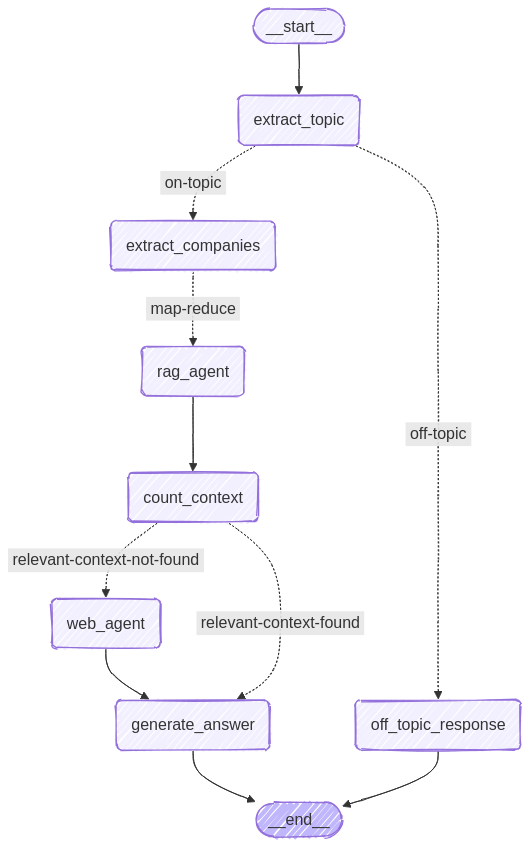

In [36]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=1).draw_mermaid_png(
    frontmatter_config={
        "config": {
            "layout": "dagre",
            "look": "handDrawn"
                }
            }
    )))

We can now stream the graph to propagate the user query through the graph-based agent in oder to generate a final answer.

In [37]:
from util import print_graph_propagation

In [25]:
# Off-topic query
query = "How is the weather in New York?"

print_graph_propagation(graph, query)

User query: How is the weather in New York?

-----------------

Graph events:
{'extract_topic': {'topic': Topic(dax_40_related=False, topic='')}}
{'off_topic_response': {'final_answer': 'Your query is not concerned about DAX 40 companies and therefore off topic within the context of this agent.'}}

-----------------

Answer: Your query is not concerned about DAX 40 companies and therefore off topic within the context of this agent.


In [26]:
# Query with specific DAX 40 companies
query = "What are the climate-related risks for Adidas and BMW?"

print_graph_propagation(graph, query)

User query: What are the climate-related risks for Adidas and BMW?

-----------------

Graph events:
{'extract_topic': {'topic': Topic(dax_40_related=True, topic='climate-related risks')}}
{'extract_companies': {'companies': [Company(name='adidas'), Company(name='bmw')]}}
{'rag_agent': {'context_report': [Document(id='07512924-8d4b-40ef-b846-9dfa66092443', metadata={'company': 'adidas', 'year': 2023}, page_content='Climate scenario analysis confirmed our previous findings that the overall global greenhouse gas emission \nlevels will be an important factor influencing the magnitude of risks and opportunities. Moreover, these \nrisks and opportunities will gain relevance for our business, especially in the medium to long term.   \nWe have categorized climate-related risks and opportunities following the ‘Task Force on Climate-Related \nFinancial Disclosures’ (‘TCFD’) framework. Given the different time horizons and complexity of climate-\nrelated risks and opportunities, the overview is 

In [38]:
# DAX 40 related query but without mentioning any specific company
query = "Which risks do corporations face due to climate change?"

print_graph_propagation(graph, query)

User query: Which risks do corporations face due to climate change?

-----------------

Graph events:
{'extract_topic': {'topic': Topic(dax_40_related=True, topic='risks corporations face due to climate change')}}
{'extract_companies': {'companies': None}}
{'rag_agent': {'context_report': [], 'context': ["The annual report of adidas does not provide any information about the topic 'risks corporations face due to climate change'."], 'context_amount': [0]}}
{'rag_agent': {'context_report': [], 'context': ["The annual report of allianz does not provide any information about the topic 'risks corporations face due to climate change'."], 'context_amount': [0]}}
{'rag_agent': {'context_report': [], 'context': ["The annual report of basf does not provide any information about the topic 'risks corporations face due to climate change'."], 'context_amount': [0]}}
{'rag_agent': {'context_report': [], 'context': ["The annual report of bayer does not provide any information about the topic 'risks co

### Deployment

In [4]:
!cd studio && langgraph dev

^C


Resources:
- [How GenAI can enhance risk management](https://www.pwc.com/us/en/industries/financial-services/library/gen-ai-and-risk-management.html)
- [Let's talk about LlamaIndex and LangChain](https://superwise.ai/blog/lets-talk-about-llamaindex-and-langchain/)
- [LlamaIndex](https://docs.llamaindex.ai/en/stable/)
- [Advanced RAG techniques - An illustrated overview](https://pub.towardsai.net/advanced-rag-techniques-an-illustrated-overview-04d193d8fec6)